This script analyzes the tuning characteristics of neurons recorded at different sites. It performs the following steps:
1. Loads relevant data
    - Preprocessed spike times
    - ECoG decoding accuracy
2. Calculates modulation depth and prefered direction for each neuron for each different set of parameters
    - Event alignment (peripheral target onset, go cue, movement onset)
    - Number of trials 
    - Significantly modulated (corrected with false discovery rate for each recording site)
    - Depth
3. Calculates statistics between recorded neuron populations
4. Plot results and save figures


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import aopy
import os
import pandas as pds
from db import dbfunctions as db
from ipywidgets import interactive, widgets
import scipy
import h5py
from tqdm.auto import tqdm 
import seaborn as sn
import sklearn
from sklearn.decomposition import PCA, FactorAnalysis
from itertools import compress
import multiprocessing as mp
import time
import math
from scipy.fft import fft
import glob
from datetime import date
from statsmodels.stats.multitest import fdrcorrection

In [2]:
save_figs = False
base_save_dir = "/media/moor-data/results/Ryan/neuropixel_targeting/"
np_preproc_data_folder = 'np_analysis_preproc_data'
ecog_dec_acc_file_name = 'ecog_decoding_maps/npinsert_ecog_decoding_all'

subject = 'beignet'
align_events = ['TARGET ONSET', 'GO CUE', 'MOVEMENT ONSET', 'ENTER TARGET']

In [3]:
# Tuning calculation parameters
min_trial_prop = 0.85
tuning_sig_level = 0.05
tavg_tuning_before = 0.1
tavg_tuning_after = 0.3
ntrial_bin_size = 96 #Number of trials in each bin to perform analysis with
ntr_early_late = 160

# Visualization parameters
colors = sn.color_palette(n_colors=9)

recording_brain_areas={'M1': [30, 56, 47, 40, 121, 48], 'PM':[11, 9, 18]}
day_colors = ['dodgerblue', 'indigo', 'violet', 'lightblue', 'mediumorchid',
              'purple', 'steelblue', 'dodgerblue', 'lightblue', 'red', 'black'] 

# Load Data

## Load ECoG decoding accuracy 

In [4]:
ecog_dec_acc = aopy.data.base.load_hdf_group(base_save_dir, ecog_dec_acc_file_name)

 ## Load preprocessed neuropixel data

In [5]:
np_data = {}
start = time.time()
for align_event in align_events:
    np_data[align_event] = aopy.data.base.pkl_read(f"{subject}_{align_event}", os.path.join(base_save_dir, np_preproc_data_folder))
print(f"{np.round((time.time()-start)/60)} min to load preprocessed data")
nrecs = len(np_data[align_event]['spike_align'])
recording_site = np_data[align_event]['recording_site'] # will be the same for all align events

# Define the time within each trial to calculate tuning
tuning_start_idx = int((np_data[align_event]['tbefore_mc']-tavg_tuning_before)*(1/np_data[align_event]['spike_bin_width_mc']))
tuning_end_idx = int((tavg_tuning_after+np_data[align_event]['tbefore_mc'])*(1/np_data[align_event]['spike_bin_width_mc']))

3.0 min to load preprocessed data


In [6]:
#### TODO move this to preprocessing ####
# Define target_idx_good
for align_event in align_events:
    np_data[align_event]['target_idx_good'] = []
    for irec in range(nrecs):
        np_data[align_event]['target_idx_good'].append(np_data[align_event]['target_idx'][irec][np_data[align_event]['good_trial_idx'][irec]])

# Redefine implant names: assume the same for all align events
implants = ['NPinsert72' if np_data[align_events[0]]['implant'][irec] == 'NP_Insert72' else 'NPinsert137' for irec in range(len(np_data[align_events[0]]['implant']))]

# ntrials_by_target = [[np.sum(target_idx_good[id]==itarget+1) for itarget in range(ntargets)] for id in range(len(dates))]
# unit_total_fr = [[len(spike_times[idate][str(unit_labels[idate][iunit])])/(np.max(spike_times[idate][str(unit_labels[idate][iunit])])-np.min(spike_times[idate][str(unit_labels[idate][iunit])])) for iunit in range(len(unit_labels[idate]))] for idate in range(len(dates))]

## Load stable units

In [7]:
qc_results = aopy.data.base.pkl_read(f"{subject}_QCunits", os.path.join(base_save_dir, np_preproc_data_folder))
stable_unit_labels = [qc_results['final_good_unit_labels'][irec] for irec in range(nrecs)]
stable_unit_idx = [qc_results['final_good_unit_idx'][irec] for irec in range(nrecs)]
nstable_unit = np.array([len(qc_results['final_good_unit_idx'][irec]) for irec in range(nrecs)])
neuron_pos = [qc_results['position'][irec] for irec in range(nrecs)]

In [8]:
# Get neurons with consistent firing rate across all trials
print(np_data[align_events[2]].keys())
print(np_data[align_events[2]]['spike_align_raster'][0].shape)

for align_event in align_events:
    np_data[align_event]['trial_fr'] = [np.sum(np_data[align_event]['spike_align_raster'][iday], axis=0)/(np_data[align_events[2]]['tbefore_mc']+np_data[align_events[2]]['tafter_mc']) for iday in range(len(np_data[align_event]['spike_align_raster']))]


dict_keys(['spike_times', 'unit_labels', 'trial_times', 'spike_align', 'spike_align_raster', 'spike_labels', 'ks_labels', 'recording_site', 'target_idx', 'good_trial_idx', 'tbefore_mc', 'tafter_mc', 'spike_bin_width_mc', 'trial_time_axis', 'implant', 'spike_pos', 'mc_entries', 'target_idx_good'])
(150, 600, 108)


# Calculate tuning properties

## Stable units across all trials

In [9]:
# Zscore the activity of each neuron (even unstable) across all trials
fr_zscore = {}
for align_event in align_events:
    temp_spike_data = np_data[align_event]['spike_align'] # Shape (ntime, ntrial, nunit)
    fr_zscore[align_event] = {'align_spikes_zscore': []}
    [fr_zscore[align_event]['align_spikes_zscore'].append((temp_spike_data[irec]-np.mean(temp_spike_data[irec], axis=(0,1)))/np.std(temp_spike_data[irec], axis=(0,1))) for irec in range(nrecs)]

/tmp/ipykernel_2267396/2697230201.py:6: RuntimeWarning: invalid value encountered in divide
  [fr_zscore[align_event]['align_spikes_zscore'].append((temp_spike_data[irec]-np.mean(temp_spike_data[irec], axis=(0,1)))/np.std(temp_spike_data[irec], axis=(0,1))) for irec in range(nrecs)]


In [10]:
# Calculate tuning parameters
tuning = {}
for align_event in align_events:
    tuning[align_event] = {}
    tuning[align_event]['tavg_by_cond_tuning'] = []
    tuning[align_event]['spike_md'] = []
    tuning[align_event]['spike_md_sig'] = []
    tuning[align_event]['spike_md_sig_idx'] = []
    tuning[align_event]['spike_pd'] = []
    tuning[align_event]['spike_pd_sig'] = []
    tuning[align_event]['spike_fit'] = []

    for irec in range(nrecs):
        ntargets = len(np.unique(np_data[align_event]['target_idx'][irec]))
        target_dir = np.linspace(0,360,ntargets, endpoint=False)
        
        tavg_by_cond_tuning_temp , _ , md_sig_temp = aopy.analysis.tuning.get_mean_fr_per_condition(np.swapaxes(fr_zscore[align_event]['align_spikes_zscore'][irec][tuning_start_idx:tuning_end_idx,:,stable_unit_idx[irec]], 1,2),np_data[align_event]['target_idx_good'][irec],True)

        fit_params, md, pd = aopy.analysis.run_tuningcurve_fit(tavg_by_cond_tuning_temp, target_dir)

        tuning[align_event]['tavg_by_cond_tuning'].append(tavg_by_cond_tuning_temp)
        tuning[align_event]['spike_md'].append(md)
        tuning[align_event]['spike_pd'].append(pd)
        tuning[align_event]['spike_fit'].append(fit_params)
        temp_sig_idx, _ = fdrcorrection(md_sig_temp, alpha=0.05)
        tuning[align_event]['spike_md_sig'].append(md[temp_sig_idx])
        tuning[align_event]['spike_md_sig_idx'].append(temp_sig_idx)
        tuning[align_event]['spike_pd_sig'].append(pd[temp_sig_idx])

 ## Trial adding

In [40]:
# Identify stable units
stable_unit_idx_nunits_tradd = {}
nstable_unit_idx_nunits_tradd = {}
for align_event in align_events:
    ntrial_adding_bins = np.sum(np_data[align_event]['good_trial_idx'][0])//ntrial_bin_size
    stable_unit_idx_nunits_tradd[align_event] = []
    for itradd_bin in range(1,ntrial_adding_bins+1):
        temp_spike_align_data = [np_data[align_event]['spike_align'][irec][:,:(itradd_bin*ntrial_bin_size),:] for irec in range(nrecs)]
        temp_stable_unit_tradd, _ = get_stable_neuropixel_units_across_recs(temp_spike_align_data,  min_trial_prop)
        stable_unit_idx_nunits_tradd[align_event].append(temp_stable_unit_tradd)

NameError: name 'get_stable_neuropixel_units_across_recs' is not defined

In [ ]:
# Zscore the activity of each neuron across all trials
# Levels: 1. align event, 2. ntrials added, 3. recording number
fr_zscore_tradd = {}
for align_event in align_events:
    fr_zscore_tradd[align_event] = {'align_spikes_zscore': []}
    for itradd_bin in range(1,ntrial_adding_bins+1):
        temp_spike_data = [np_data[align_event]['spike_align'][irec][:,:(itradd_bin*ntrial_bin_size),:] for irec in range(nrecs)] # Shape (ntime, ntrial, nunit)
        fr_zscore_tradd[align_event]['align_spikes_zscore'].append([(temp_spike_data[irec]-np.mean(temp_spike_data[irec], axis=(0,1)))/np.std(temp_spike_data[irec], axis=(0,1)) for irec in range(nrecs)])

In [ ]:
# Calculate tuning parameters
tuning_tradd = {}
for align_event in tqdm(align_events):
    tuning_tradd[align_event] = {}
    tuning_tradd[align_event]['tavg_by_cond_tuning'] = []
    tuning_tradd[align_event]['spike_md'] = []
    tuning_tradd[align_event]['spike_md_sig'] = []
    tuning_tradd[align_event]['spike_md_sig_idx'] = []
    tuning_tradd[align_event]['spike_pd'] = []
    tuning_tradd[align_event]['spike_pd_sig'] = []
    tuning_tradd[align_event]['spike_fit'] = []
    for itradd_bin in range(ntrial_adding_bins):
        tavg_by_cond_tuning_tradd_temp = []
        spike_md_tradd_temp = []
        spike_md_sig_temp = []
        spike_md_sig_idx_tradd_temp = []
        spike_pd_tradd_temp = []
        spike_pd_sig_tradd_temp = []
        spike_fit_tradd_temp = []
        
        for irec in range(nrecs):
            ntargets = len(np.unique(np_data[align_event]['target_idx'][irec]))
            target_dir = np.linspace(0,360,ntargets, endpoint=False)

            tavg_by_cond_tuning_temp , _ , md_sig_temp = aopy.analysis.tuning.get_mean_fr_per_condition(np.swapaxes(fr_zscore_tradd[align_event]['align_spikes_zscore'][itradd_bin][irec][tuning_start_idx:tuning_end_idx,:,stable_unit_idx_nunits_tradd[align_event][itradd_bin][irec]], 1,2),np_data[align_event]['target_idx_good'][irec][:((1+itradd_bin)*ntrial_bin_size)],True)

            fit_params, md, pd = aopy.analysis.run_tuningcurve_fit(tavg_by_cond_tuning_temp, target_dir)

            tavg_by_cond_tuning_tradd_temp.append(tavg_by_cond_tuning_temp)
            spike_md_tradd_temp.append(md)
            spike_pd_tradd_temp.append(pd)
            spike_fit_tradd_temp.append(fit_params)
            temp_sig_idx, _ = fdrcorrection(md_sig_temp, alpha=0.05)
            spike_md_sig_temp.append(md[temp_sig_idx])
            spike_md_sig_idx_tradd_temp.append(temp_sig_idx)
            spike_pd_sig_tradd_temp.append(pd[temp_sig_idx])
        
        tuning_tradd[align_event]['tavg_by_cond_tuning'].append(tavg_by_cond_tuning_tradd_temp)
        tuning_tradd[align_event]['spike_md'].append(spike_md_tradd_temp)
        tuning_tradd[align_event]['spike_pd'].append(spike_pd_tradd_temp)
        tuning_tradd[align_event]['spike_fit'].append(spike_fit_tradd_temp)
        tuning_tradd[align_event]['spike_md_sig'].append(spike_md_sig_temp)
        tuning_tradd[align_event]['spike_md_sig_idx'].append(spike_md_sig_idx_tradd_temp)
        tuning_tradd[align_event]['spike_pd_sig'].append(spike_pd_sig_tradd_temp)

## Early - late comparison

In [41]:
# Calculate tuning on early trials for all units
for align_event in align_events:
    tuning[align_event]['early_tavg_by_cond_tuning'] = []
    tuning[align_event]['early_spike_md'] = []
    tuning[align_event]['early_spike_md_sig'] = []
    tuning[align_event]['early_spike_md_sig_idx'] = []
    tuning[align_event]['early_spike_pd'] = []
    tuning[align_event]['early_spike_pd_sig'] = []
    tuning[align_event]['early_spike_fit'] = []

    for irec in range(nrecs):
        ntargets = len(np.unique(np_data[align_event]['target_idx'][irec]))
        target_dir = np.linspace(0,360,ntargets, endpoint=False)
        
        tavg_by_cond_tuning_temp , _ , md_sig_temp = aopy.analysis.tuning.get_mean_fr_per_condition(np.swapaxes(fr_zscore[align_event]['align_spikes_zscore'][irec][tuning_start_idx:tuning_end_idx,:ntr_early_late,:], 1,2),np_data[align_event]['target_idx_good'][irec][:ntr_early_late],True)

        fit_params, md, pd = aopy.analysis.run_tuningcurve_fit(tavg_by_cond_tuning_temp, target_dir)
        tuning[align_event]['early_tavg_by_cond_tuning'].append(tavg_by_cond_tuning_temp)
        tuning[align_event]['early_spike_md'].append(md)
        tuning[align_event]['early_spike_pd'].append(pd)
        tuning[align_event]['early_spike_fit'].append(fit_params)
        temp_sig_idx, _ = fdrcorrection(md_sig_temp, alpha=0.05)
        tuning[align_event]['early_spike_md_sig'].append(md[temp_sig_idx])
        tuning[align_event]['early_spike_md_sig_idx'].append(temp_sig_idx)
        tuning[align_event]['early_spike_pd_sig'].append(pd[temp_sig_idx])

/home/aolab/miniconda3/envs/np_targeting/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
/home/aolab/miniconda3/envs/np_targeting/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [42]:
# Calculate tuning on early trials for all units
for align_event in align_events:
    tuning[align_event]['late_tavg_by_cond_tuning'] = []
    tuning[align_event]['late_spike_md'] = []
    tuning[align_event]['late_spike_md_sig'] = []
    tuning[align_event]['late_spike_md_sig_idx'] = []
    tuning[align_event]['late_spike_pd'] = []
    tuning[align_event]['late_spike_pd_sig'] = []
    tuning[align_event]['late_spike_fit'] = []

    for irec in range(nrecs):
        ntargets = len(np.unique(np_data[align_event]['target_idx'][irec]))
        target_dir = np.linspace(0,360,ntargets, endpoint=False)
        
        tavg_by_cond_tuning_temp , _ , md_sig_temp = aopy.analysis.tuning.get_mean_fr_per_condition(np.swapaxes(fr_zscore[align_event]['align_spikes_zscore'][irec][tuning_start_idx:tuning_end_idx,-ntr_early_late:,:], 1,2),np_data[align_event]['target_idx_good'][irec][-ntr_early_late:],True)

        fit_params, md, pd = aopy.analysis.run_tuningcurve_fit(tavg_by_cond_tuning_temp, target_dir)
        tuning[align_event]['late_tavg_by_cond_tuning'].append(tavg_by_cond_tuning_temp)
        tuning[align_event]['late_spike_md'].append(md)
        tuning[align_event]['late_spike_pd'].append(pd)
        tuning[align_event]['late_spike_fit'].append(fit_params)
        temp_sig_idx, _ = fdrcorrection(md_sig_temp, alpha=0.05)
        tuning[align_event]['late_spike_md_sig'].append(md[temp_sig_idx])
        tuning[align_event]['late_spike_md_sig_idx'].append(temp_sig_idx)
        tuning[align_event]['late_spike_pd_sig'].append(pd[temp_sig_idx])

In [43]:
# Get units with consistent tuning between early and late
delta_pd_thresh = np.deg2rad(45)
delta_pd = [np.abs(tuning[align_events[-1]]['early_spike_pd'][irec][stable_unit_idx[irec]] - tuning[align_events[-1]]['late_spike_pd'][irec][stable_unit_idx[irec]]) for irec in range(nrecs)]
consistent_unit_labels = [stable_unit_labels[irec][np.logical_or((delta_pd[irec] < delta_pd_thresh), delta_pd[irec] > (2*np.pi-delta_pd_thresh))] for irec in range(nrecs)]
consistent_unit_idx = [stable_unit_idx[irec][np.logical_or((delta_pd[irec] < delta_pd_thresh), delta_pd[irec] > (2*np.pi-delta_pd_thresh))] for irec in range(nrecs)]

In [44]:
# Calculate tuning parameters for consistent neurons
for align_event in align_events:
    tuning[align_event]['cons_tavg_by_cond_tuning'] = []
    tuning[align_event]['cons_spike_md'] = []
    tuning[align_event]['cons_spike_md_sig'] = []
    tuning[align_event]['cons_spike_md_sig_idx'] = []
    tuning[align_event]['cons_spike_pd'] = []
    tuning[align_event]['cons_spike_pd_sig'] = []
    tuning[align_event]['cons_spike_fit'] = []

    for irec in range(nrecs):
        ntargets = len(np.unique(np_data[align_event]['target_idx'][irec]))
        target_dir = np.linspace(0,360,ntargets, endpoint=False)
        
        tavg_by_cond_tuning_temp , _ , md_sig_temp = aopy.analysis.tuning.get_mean_fr_per_condition(np.swapaxes(fr_zscore[align_event]['align_spikes_zscore'][irec][tuning_start_idx:tuning_end_idx,:,consistent_unit_idx[irec]], 1,2),np_data[align_event]['target_idx_good'][irec],True)

        fit_params, md, pd = aopy.analysis.run_tuningcurve_fit(tavg_by_cond_tuning_temp, target_dir)

        tuning[align_event]['cons_tavg_by_cond_tuning'].append(tavg_by_cond_tuning_temp)
        tuning[align_event]['cons_spike_md'].append(md)
        tuning[align_event]['cons_spike_pd'].append(pd)
        tuning[align_event]['cons_spike_fit'].append(fit_params)
        temp_sig_idx, _ = fdrcorrection(md_sig_temp, alpha=0.05)
        tuning[align_event]['cons_spike_md_sig'].append(md[temp_sig_idx])
        tuning[align_event]['cons_spike_md_sig_idx'].append(temp_sig_idx)
        tuning[align_event]['cons_spike_pd_sig'].append(pd[temp_sig_idx])

## Tuning change during trial (timing information)

In [11]:
tuning['timing'] = {}
tuning['timing']['delta_Mon-Ton'] = [tuning[align_events[2]]['spike_md'][irec] - tuning[align_events[0]]['spike_md'][irec] for irec in range(nrecs)]

# Calculate statistics between neuron populations

In [12]:
# define ecog decoding accuracy as one variable to make it easier to do further analysis
ecog_dec_acc_rec_site = {}
for align_event in align_events:
    ecog_dec_acc_rec_site[align_event] = [ecog_dec_acc['beignet'][f"{implants[irec]}_interp"][rec_site-1] for irec, rec_site in enumerate(np_data[align_event]['recording_site'])]

## Across all trials

In [13]:
# Fit linear regression to MD plots
for align_event in align_events:
    md_lin_reg_x = []
    md_lin_reg_y = []
    md_lin_reg_x_M1 = []
    md_lin_reg_y_M1 = []
    md_lin_reg_x_PM = []
    md_lin_reg_y_PM = []
    for irec, rec_site in enumerate(np_data[align_event]['recording_site']):
        md_lin_reg_x.extend(np.zeros(tuning[align_event]['spike_md'][irec].shape)+100*ecog_dec_acc_rec_site[align_event][irec])
        md_lin_reg_y.extend(tuning[align_event]['spike_md'][irec])

        if rec_site in recording_brain_areas['M1']:
            md_lin_reg_x_M1.extend(np.zeros(tuning[align_event]['spike_md'][irec].shape)+100*ecog_dec_acc_rec_site[align_event][irec])
            md_lin_reg_y_M1.extend(tuning[align_event]['spike_md'][irec])

        if rec_site in recording_brain_areas['PM']:
            md_lin_reg_x_PM.extend(np.zeros(tuning[align_event]['spike_md'][irec].shape)+100*ecog_dec_acc_rec_site[align_event][irec])
            md_lin_reg_y_PM.extend(tuning[align_event]['spike_md'][irec])

    _, _, tuning[align_event]['spike_md_pcc'], tuning[align_event]['spike_md_pcc_pval'], tuning[align_event]['spike_md_reg_fit'] = aopy.analysis.base.linear_fit_analysis2D(np.array(md_lin_reg_x)[:,None], np.array(md_lin_reg_y)[:,None])
    _, _, tuning[align_event]['spike_md_pcc_M1'], tuning[align_event]['spike_md_pcc_pval_M1'], tuning[align_event]['spike_md_reg_fit_M1'] = aopy.analysis.base.linear_fit_analysis2D(np.array(md_lin_reg_x_M1)[:,None], np.array(md_lin_reg_y_M1)[:,None])
    _, _, tuning[align_event]['spike_md_pcc_PM'], tuning[align_event]['spike_md_pcc_pval_PM'], tuning[align_event]['spike_md_reg_fit_PM'] = aopy.analysis.base.linear_fit_analysis2D(np.array(md_lin_reg_x_PM)[:,None], np.array(md_lin_reg_y_PM)[:,None])

In [14]:
# Fit linear regression to MD plots for only significantly modulated units
# Fit linear regression to MD plots
for align_event in align_events:
    md_lin_reg_x = []
    md_lin_reg_y = []
    md_lin_reg_x_M1 = []
    md_lin_reg_y_M1 = []
    md_lin_reg_x_PM = []
    md_lin_reg_y_PM = []
    for irec, rec_site in enumerate(np_data[align_event]['recording_site']):
        md_lin_reg_x.extend(np.zeros(tuning[align_event]['spike_md_sig'][irec].shape)+100*ecog_dec_acc_rec_site[align_event][irec])
        md_lin_reg_y.extend(tuning[align_event]['spike_md_sig'][irec])

        if rec_site in recording_brain_areas['M1']:
            md_lin_reg_x_M1.extend(np.zeros(tuning[align_event]['spike_md_sig'][irec].shape)+100*ecog_dec_acc_rec_site[align_event][irec])
            md_lin_reg_y_M1.extend(tuning[align_event]['spike_md_sig'][irec])

        if rec_site in recording_brain_areas['PM']:
            md_lin_reg_x_PM.extend(np.zeros(tuning[align_event]['spike_md_sig'][irec].shape)+100*ecog_dec_acc_rec_site[align_event][irec])
            md_lin_reg_y_PM.extend(tuning[align_event]['spike_md_sig'][irec])

    _, _, tuning[align_event]['spike_md_pcc_sig'], tuning[align_event]['spike_md_pcc_pval_sig'], tuning[align_event]['spike_md_reg_fit_sig'] = aopy.analysis.base.linear_fit_analysis2D(np.array(md_lin_reg_x)[:,None], np.array(md_lin_reg_y)[:,None])
    _, _, tuning[align_event]['spike_md_pcc_M1_sig'], tuning[align_event]['spike_md_pcc_pval_M1_sig'], tuning[align_event]['spike_md_reg_fit_M1_sig'] = aopy.analysis.base.linear_fit_analysis2D(np.array(md_lin_reg_x_M1)[:,None], np.array(md_lin_reg_y_M1)[:,None])
    _, _, tuning[align_event]['spike_md_pcc_PM_sig'], tuning[align_event]['spike_md_pcc_pval_PM_sig'], tuning[align_event]['spike_md_reg_fit_PM_sig'] = aopy.analysis.base.linear_fit_analysis2D(np.array(md_lin_reg_x_PM)[:,None], np.array(md_lin_reg_y_PM)[:,None])

## Trial adding

In [ ]:
# Fit linear regression to MD plots
for align_event in align_events:
    tuning_tradd[align_event]['spike_md_pcc'] = []
    tuning_tradd[align_event]['spike_md_pcc_pval'] = []
    tuning_tradd[align_event]['spike_md_reg_fit'] = []
    tuning_tradd[align_event]['spike_md_pcc_M1'] = []
    tuning_tradd[align_event]['spike_md_pcc_pval_M1'] = []
    tuning_tradd[align_event]['spike_md_reg_fit_M1'] = []
    tuning_tradd[align_event]['spike_md_pcc_PM'] = []
    tuning_tradd[align_event]['spike_md_pcc_pval_PM'] = []
    tuning_tradd[align_event]['spike_md_reg_fit_PM'] = []
    for itradd_bin in range(ntrial_adding_bins):
        md_lin_reg_x = []
        md_lin_reg_y = []
        md_lin_reg_x_M1 = []
        md_lin_reg_y_M1 = []
        md_lin_reg_x_PM = []
        md_lin_reg_y_PM = []
        for irec, rec_site in enumerate(np_data[align_event]['recording_site']):
            md_lin_reg_x.extend(np.zeros(tuning_tradd[align_event]['spike_md'][itradd_bin][irec].shape)+100*ecog_dec_acc_rec_site[align_event][irec])
            md_lin_reg_y.extend(tuning_tradd[align_event]['spike_md'][itradd_bin][irec])
        
            if rec_site in recording_brain_areas['M1']:
                md_lin_reg_x_M1.extend(np.zeros(tuning_tradd[align_event]['spike_md'][itradd_bin][irec].shape)+100*ecog_dec_acc_rec_site[align_event][irec])
                md_lin_reg_y_M1.extend(tuning_tradd[align_event]['spike_md'][itradd_bin][irec])

            if rec_site in recording_brain_areas['PM']:
                md_lin_reg_x_PM.extend(np.zeros(tuning_tradd[align_event]['spike_md'][itradd_bin][irec].shape)+100*ecog_dec_acc_rec_site[align_event][irec])
                md_lin_reg_y_PM.extend(tuning_tradd[align_event]['spike_md'][itradd_bin][irec])
        
        _, _, temp1, temp2, temp3 = aopy.analysis.base.linear_fit_analysis2D(np.array(md_lin_reg_x)[:,None], np.array(md_lin_reg_y)[:,None])
        _, _, temp1_M1, temp2_M1, temp3_M1 = aopy.analysis.base.linear_fit_analysis2D(np.array(md_lin_reg_x_M1)[:,None], np.array(md_lin_reg_y_M1)[:,None])
        _, _, temp1_PM, temp2_PM, temp3_PM = aopy.analysis.base.linear_fit_analysis2D(np.array(md_lin_reg_x_PM)[:,None], np.array(md_lin_reg_y_PM)[:,None])
        
        tuning_tradd[align_event]['spike_md_pcc'].append(temp1)
        tuning_tradd[align_event]['spike_md_pcc_pval'].append(temp2)
        tuning_tradd[align_event]['spike_md_reg_fit'].append(temp3)
        tuning_tradd[align_event]['spike_md_pcc_M1'].append(temp1_M1)
        tuning_tradd[align_event]['spike_md_pcc_pval_M1'].append(temp2_M1)
        tuning_tradd[align_event]['spike_md_reg_fit_M1'].append(temp3_M1)
        tuning_tradd[align_event]['spike_md_pcc_PM'].append(temp1_PM)
        tuning_tradd[align_event]['spike_md_pcc_pval_PM'].append(temp2_PM)
        tuning_tradd[align_event]['spike_md_reg_fit_PM'].append(temp3_PM)

In [ ]:
# Fit linear regression to MD plots
for align_event in align_events:
    tuning_tradd[align_event]['spike_md_pcc_sig'] = []
    tuning_tradd[align_event]['spike_md_pcc_pval_sig'] = []
    tuning_tradd[align_event]['spike_md_reg_fit_sig'] = []
    tuning_tradd[align_event]['spike_md_pcc_M1_sig'] = []
    tuning_tradd[align_event]['spike_md_pcc_pval_M1_sig'] = []
    tuning_tradd[align_event]['spike_md_reg_fit_M1_sig'] = []
    tuning_tradd[align_event]['spike_md_pcc_PM_sig'] = []
    tuning_tradd[align_event]['spike_md_pcc_pval_PM_sig'] = []
    tuning_tradd[align_event]['spike_md_reg_fit_PM_sig'] = []
    for itradd_bin in range(ntrial_adding_bins):
        md_lin_reg_x = []
        md_lin_reg_y = []
        md_lin_reg_x_M1 = []
        md_lin_reg_y_M1 = []
        md_lin_reg_x_PM = []
        md_lin_reg_y_PM = []
        for irec, rec_site in enumerate(np_data[align_event]['recording_site']):
            md_lin_reg_x.extend(np.zeros(tuning_tradd[align_event]['spike_md_sig'][itradd_bin][irec].shape)+100*ecog_dec_acc_rec_site[align_event][irec])
            md_lin_reg_y.extend(tuning_tradd[align_event]['spike_md_sig'][itradd_bin][irec])
        
            if rec_site in recording_brain_areas['M1']:
                md_lin_reg_x_M1.extend(np.zeros(tuning_tradd[align_event]['spike_md_sig'][itradd_bin][irec].shape)+100*ecog_dec_acc_rec_site[align_event][irec])
                md_lin_reg_y_M1.extend(tuning_tradd[align_event]['spike_md_sig'][itradd_bin][irec])

            if rec_site in recording_brain_areas['PM']:
                md_lin_reg_x_PM.extend(np.zeros(tuning_tradd[align_event]['spike_md_sig'][itradd_bin][irec].shape)+100*ecog_dec_acc_rec_site[align_event][irec])
                md_lin_reg_y_PM.extend(tuning_tradd[align_event]['spike_md_sig'][itradd_bin][irec])
        
        _, _, temp1, temp2, temp3 = aopy.analysis.base.linear_fit_analysis2D(np.array(md_lin_reg_x)[:,None], np.array(md_lin_reg_y)[:,None])
        _, _, temp1_M1, temp2_M1, temp3_M1 = aopy.analysis.base.linear_fit_analysis2D(np.array(md_lin_reg_x_M1)[:,None], np.array(md_lin_reg_y_M1)[:,None])
        _, _, temp1_PM, temp2_PM, temp3_PM = aopy.analysis.base.linear_fit_analysis2D(np.array(md_lin_reg_x_PM)[:,None], np.array(md_lin_reg_y_PM)[:,None])
        
        tuning_tradd[align_event]['spike_md_pcc_sig'].append(temp1)
        tuning_tradd[align_event]['spike_md_pcc_pval_sig'].append(temp2)
        tuning_tradd[align_event]['spike_md_reg_fit_sig'].append(temp3)
        tuning_tradd[align_event]['spike_md_pcc_M1_sig'].append(temp1_M1)
        tuning_tradd[align_event]['spike_md_pcc_pval_M1_sig'].append(temp2_M1)
        tuning_tradd[align_event]['spike_md_reg_fit_M1_sig'].append(temp3_M1)
        tuning_tradd[align_event]['spike_md_pcc_PM_sig'].append(temp1_PM)
        tuning_tradd[align_event]['spike_md_pcc_pval_PM_sig'].append(temp2_PM)
        tuning_tradd[align_event]['spike_md_reg_fit_PM_sig'].append(temp3_PM)

# Plot results

## All stable units across all trials

### All recording sites

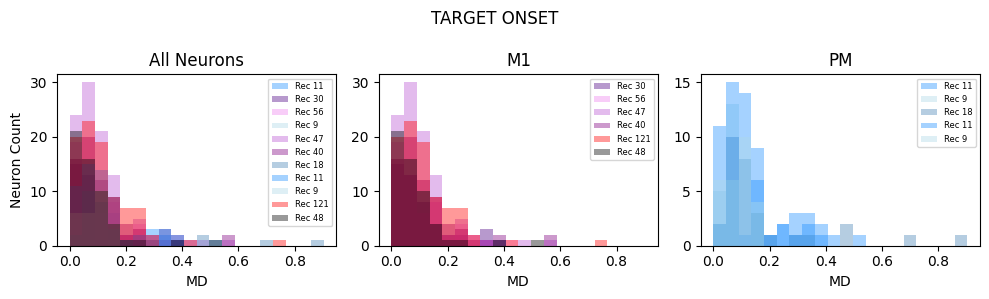

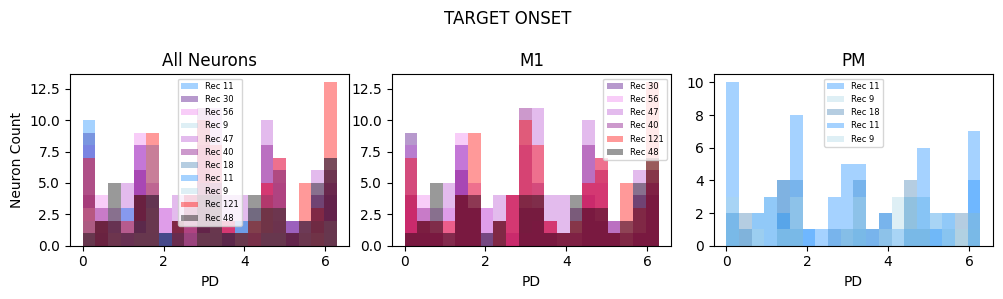

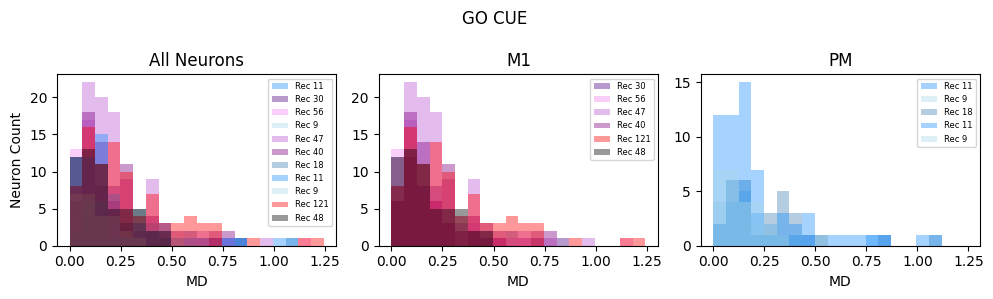

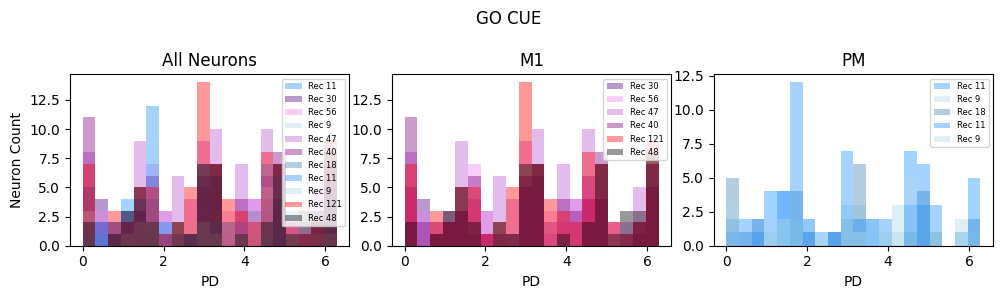

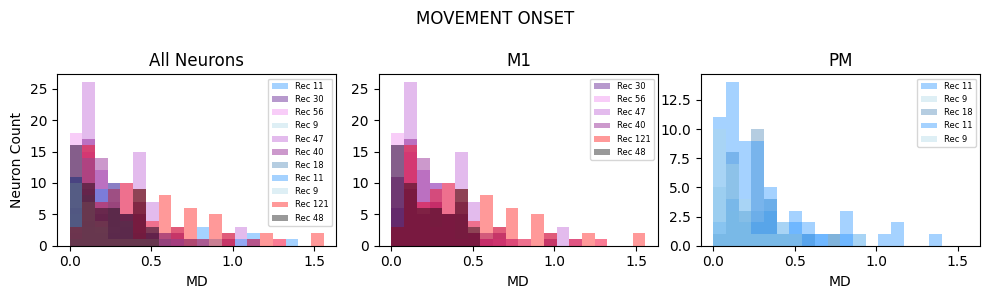

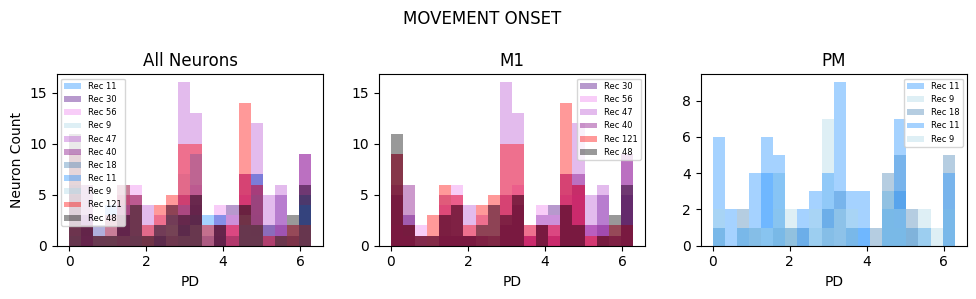

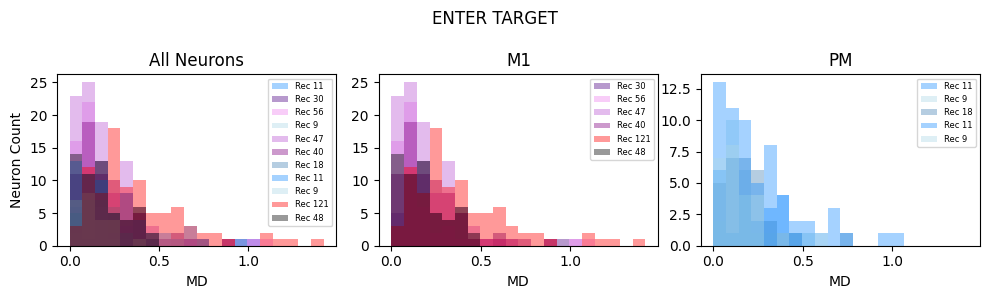

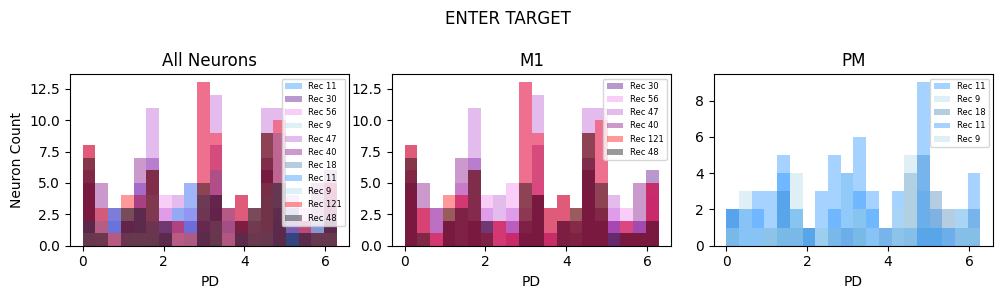

In [15]:
# Basic tuning parameter histograms
for align_event in align_events:
    max_tuning_zscore = np.max([np.max(tuning[align_event]['spike_md'][irec].flatten()) for irec in range(nrecs)])
    fig, ax = plt.subplots(1,3,figsize=(10,3))
    [ax[0].hist(tuning[align_event]['spike_md'][irec], bins=20, range=(0, max_tuning_zscore), alpha=0.4,color=day_colors[irec], label=f'Rec {recording_site[irec]}') for irec in range(nrecs)]
    [ax[1].hist(tuning[align_event]['spike_md'][irec], bins=20, range=(0, max_tuning_zscore), alpha=0.4,color=day_colors[irec], label=f'Rec {recording_site[irec]}') for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['M1']]
    [ax[2].hist(tuning[align_event]['spike_md'][irec], bins=20, range=(0, max_tuning_zscore), alpha=0.4,color=day_colors[irec], label=f'Rec {recording_site[irec]}') for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['PM']]
    ax[0].set(xlabel='MD', ylabel='Neuron Count', title='All Neurons')
    ax[1].set(xlabel='MD', title='M1')
    ax[2].set(xlabel='MD', title='PM')
    [ax[irec].legend(fontsize=6) for irec in range(len(ax))]
    plt.suptitle(f"{align_event}")
    fig.tight_layout()
    plt.show()

    fig, ax = plt.subplots(1,3,figsize=(10,3))
    [ax[0].hist(tuning[align_event]['spike_pd'][irec], bins=20, range=(0, 2*np.pi), alpha=0.4,color=day_colors[irec], label=f'Rec {recording_site[irec]}') for irec in range(nrecs)]
    [ax[1].hist(tuning[align_event]['spike_pd'][irec], bins=20, range=(0, 2*np.pi), alpha=0.4,color=day_colors[irec], label=f'Rec {recording_site[irec]}') for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['M1']]
    [ax[2].hist(tuning[align_event]['spike_pd'][irec], bins=20, range=(0, 2*np.pi), alpha=0.4,color=day_colors[irec], label=f'Rec {recording_site[irec]}') for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['PM']]
    ax[0].set(xlabel='PD', ylabel='Neuron Count', title='All Neurons')
    ax[1].set(xlabel='PD', title='M1')
    ax[2].set(xlabel='PD', title='PM')
    [ax[irec].legend(fontsize=6) for irec in range(len(ax))]
    plt.suptitle(f"{align_event}")
    fig.tight_layout()
    plt.show()

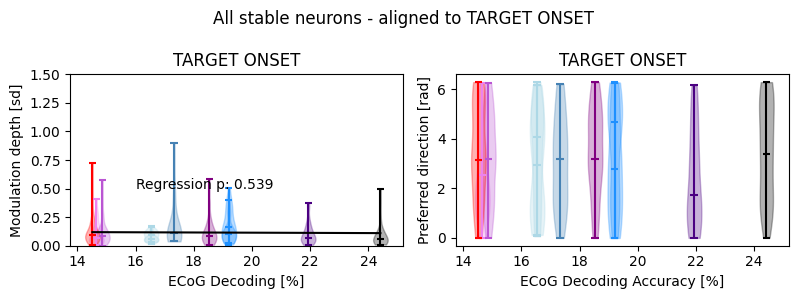

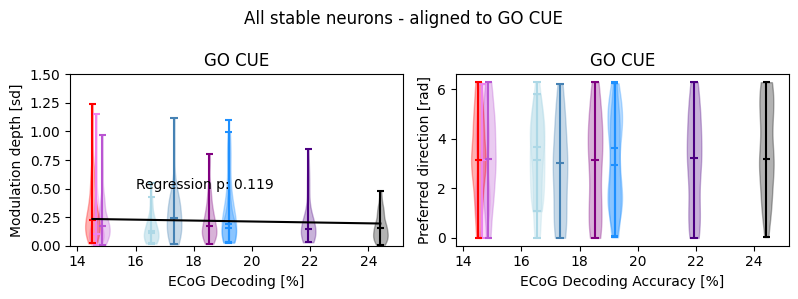

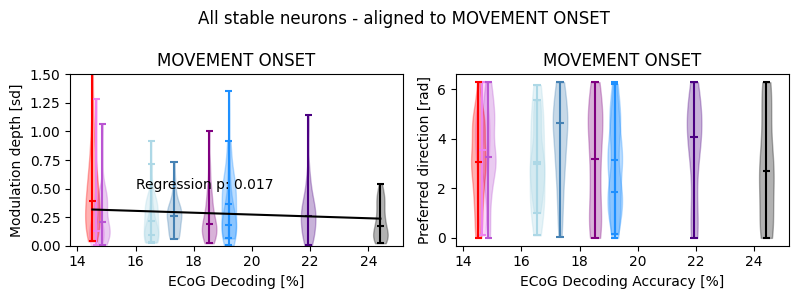

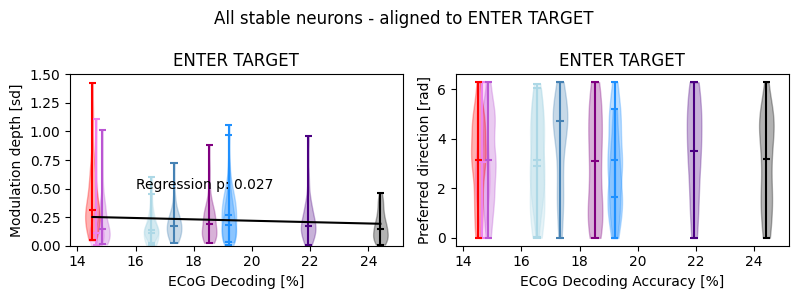

In [16]:
for align_event in align_events:
    fig, ax = plt.subplots(1,2,figsize=(8,3))
    vplts = [ax[0].violinplot(tuning[align_event]['spike_md'][irec], positions=[100*ecog_dec_acc_rec_site[align_event][irec]], showmedians=True, showmeans=False) for irec in range(nrecs)]
    [vplts[irec]['bodies'][0].set_color(day_colors[irec]) for irec in range(nrecs)]
    [vplts[irec]['cbars'].set_colors(day_colors[irec]) for irec in range(nrecs)]
    [vplts[irec]['cmedians'].set_colors(day_colors[irec]) for irec in range(nrecs)]
    [vplts[irec]['cmins'].set_colors(day_colors[irec]) for irec in range(nrecs)]
    [vplts[irec]['cmaxes'].set_colors(day_colors[irec]) for irec in range(nrecs)]
    ax[0].set(xlabel='ECoG Decoding [%]', ylabel='Modulation depth [sd]', ylim=(0,1.5), title=align_event)

    ax[0].plot([100*np.min(ecog_dec_acc_rec_site[align_event]), 100*np.max(ecog_dec_acc_rec_site[align_event])], [(tuning[align_event]['spike_md_reg_fit'].coef_*100*np.min(ecog_dec_acc_rec_site[align_event])+tuning[align_event]['spike_md_reg_fit'].intercept_)[0], (tuning[align_event]['spike_md_reg_fit'].coef_*100*np.max(ecog_dec_acc_rec_site[align_event])+tuning[align_event]['spike_md_reg_fit'].intercept_)[0]], 'k')
    ax[0].annotate(f"Regression p: {np.round(tuning[align_event]['spike_md_pcc_pval'],3)}", (16, 0.5))

    vplts1 = [ax[1].violinplot(tuning[align_event]['spike_pd'][irec], positions=[100*ecog_dec_acc_rec_site[align_event][irec]], showmedians=True, showmeans=False) for irec in range(nrecs)]
    [vplts1[irec]['bodies'][0].set_color(day_colors[irec]) for irec in range(nrecs)]
    [vplts1[irec]['cbars'].set_colors(day_colors[irec]) for irec in range(nrecs)]
    [vplts1[irec]['cmedians'].set_colors(day_colors[irec]) for irec in range(nrecs)]
    [vplts1[irec]['cmins'].set_colors(day_colors[irec]) for irec in range(nrecs)]
    [vplts1[irec]['cmaxes'].set_colors(day_colors[irec]) for irec in range(nrecs)]
    ax[1].set(ylabel='Preferred direction [rad]', xlabel='ECoG Decoding Accuracy [%]', title=align_event)
    fig.suptitle(f"All stable neurons - aligned to {align_event}")
    fig.tight_layout()
    plt.show()

### Split by brain area

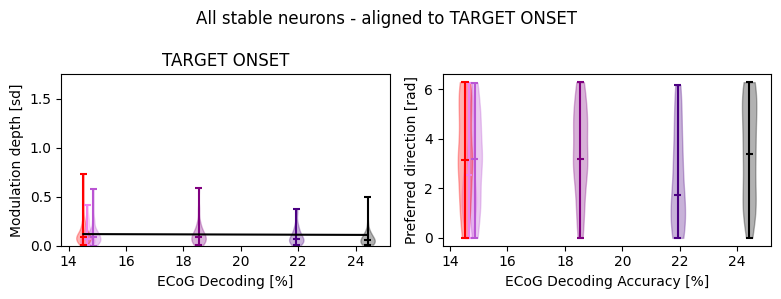

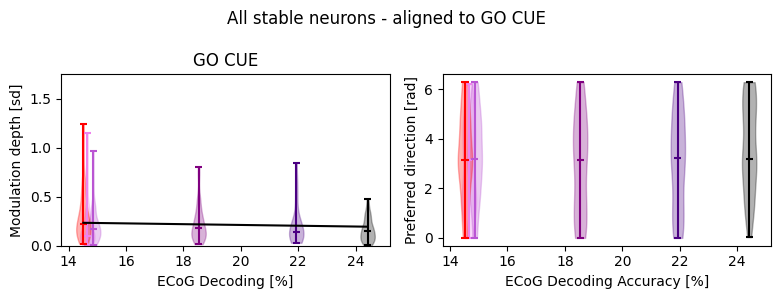

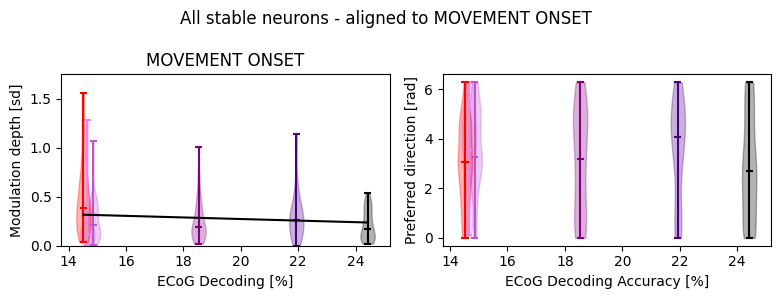

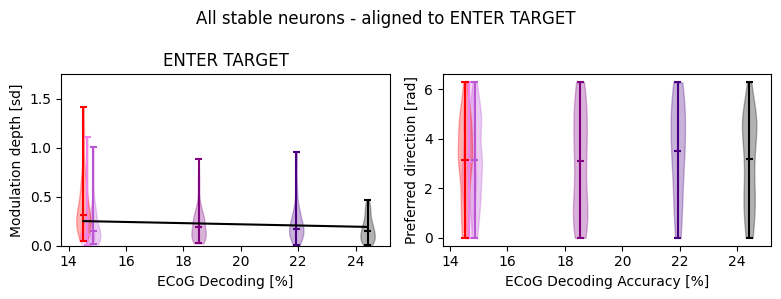

In [17]:
# M1
for align_event in align_events:
    fig, ax = plt.subplots(1,2,figsize=(8,3))
    vplts = [ax[0].violinplot(tuning[align_event]['spike_md'][irec], positions=[100*ecog_dec_acc['beignet'][f"{implants[irec]}_interp"][recording_site[irec]-1]], showmedians=True, showmeans=False) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['M1']]
    # [vpltsM1sm[ip]['bodies'][0].set_color(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['M1']))[0][ip]]) for ip in range(len(vpltsM1sm))]
    [vplts[irec]['bodies'][0].set_color(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['M1']))[0][irec]]) for irec in range(len(vplts))]
    [vplts[irec]['cbars'].set_colors(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['M1']))[0][irec]]) for irec in range(len(vplts))]
    [vplts[irec]['cmedians'].set_colors(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['M1']))[0][irec]]) for irec in range(len(vplts))]
    [vplts[irec]['cmins'].set_colors(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['M1']))[0][irec]]) for irec in range(len(vplts))]
    [vplts[irec]['cmaxes'].set_colors(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['M1']))[0][irec]]) for irec in range(len(vplts))]
    ax[0].set(xlabel='ECoG Decoding [%]', ylabel='Modulation depth [sd]', ylim=(0,1.75),title=align_event)

    ax[0].plot([100*np.min(np.array(ecog_dec_acc_rec_site[align_event])[np.where(np.in1d(recording_site,recording_brain_areas['M1']))[0]]), 100*np.max(np.array(ecog_dec_acc_rec_site[align_event])[np.where(np.in1d(recording_site,recording_brain_areas['M1']))[0]])], [(tuning[align_event]['spike_md_reg_fit'].coef_*100*np.min(np.array(ecog_dec_acc_rec_site[align_event])[np.where(np.in1d(recording_site,recording_brain_areas['M1']))[0]])+tuning[align_event]['spike_md_reg_fit'].intercept_)[0], (tuning[align_event]['spike_md_reg_fit'].coef_*100*np.max(np.array(ecog_dec_acc_rec_site[align_event])[np.where(np.in1d(recording_site,recording_brain_areas['M1']))[0]])+tuning[align_event]['spike_md_reg_fit'].intercept_)[0]], 'k')
    ax[0].annotate(f"Regression p: {np.round(tuning[align_event]['spike_md_pcc_pval_M1'],3)}", (3, 0.5))

    vplts1 = [ax[1].violinplot(tuning[align_event]['spike_pd'][irec], positions=[100*ecog_dec_acc['beignet'][f"{implants[irec]}_interp"][recording_site[irec]-1]], showmedians=True, showmeans=False) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['M1']]
    [vplts1[irec]['bodies'][0].set_color(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['M1']))[0][irec]]) for irec in range(len(vplts))]
    [vplts1[irec]['cbars'].set_colors(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['M1']))[0][irec]]) for irec in range(len(vplts))]
    [vplts1[irec]['cmedians'].set_colors(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['M1']))[0][irec]]) for irec in range(len(vplts))]
    [vplts1[irec]['cmins'].set_colors(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['M1']))[0][irec]]) for irec in range(len(vplts))]
    [vplts1[irec]['cmaxes'].set_colors(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['M1']))[0][irec]]) for irec in range(len(vplts))]
    ax[1].set(ylabel='Preferred direction [rad]', xlabel='ECoG Decoding Accuracy [%]')
    fig.suptitle(f"All stable neurons - aligned to {align_event}")
    fig.tight_layout()
    plt.show()

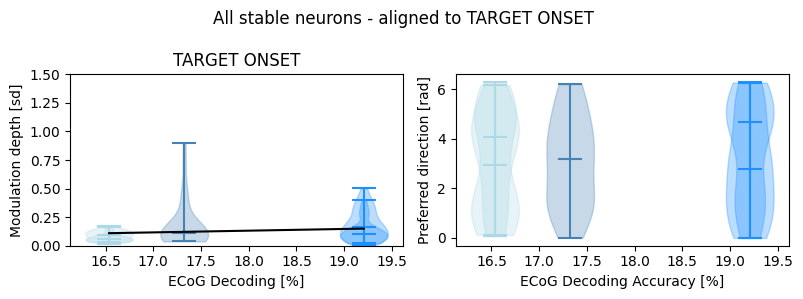

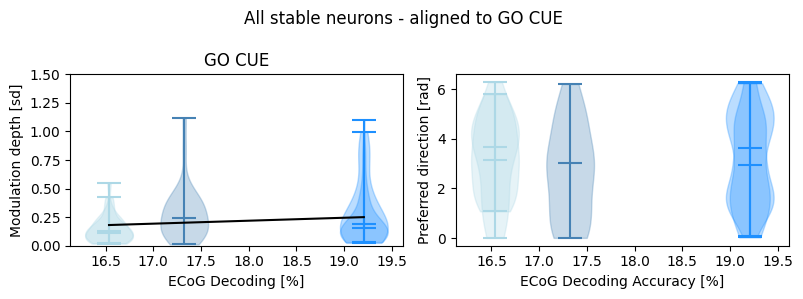

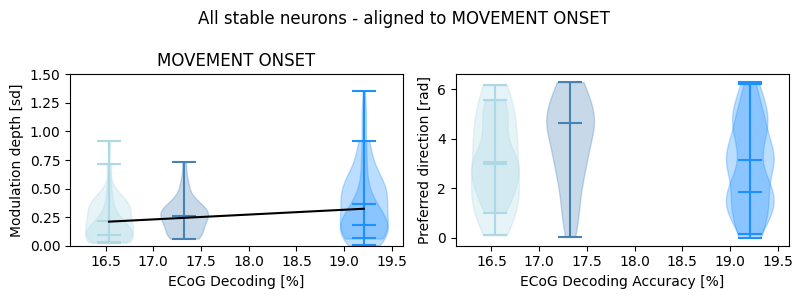

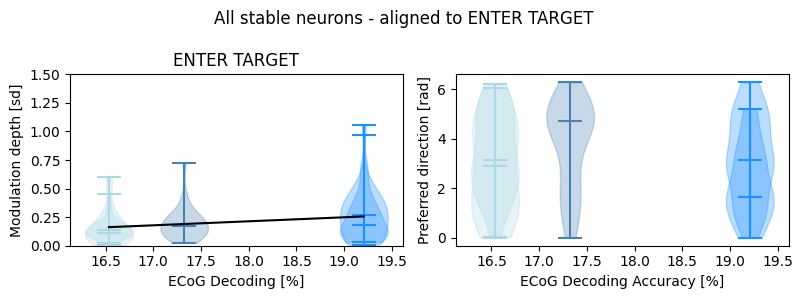

In [18]:
# PM
for align_event in align_events:
    fig, ax = plt.subplots(1,2,figsize=(8,3))
    vplts = [ax[0].violinplot(tuning[align_event]['spike_md'][irec], positions=[100*ecog_dec_acc['beignet'][f"{implants[irec]}_interp"][recording_site[irec]-1]], showmedians=True, showmeans=False) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['PM']]
    [vplts[irec]['bodies'][0].set_color(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['PM']))[0][irec]]) for irec in range(len(vplts))]
    [vplts[irec]['cbars'].set_colors(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['PM']))[0][irec]]) for irec in range(len(vplts))]
    [vplts[irec]['cmedians'].set_colors(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['PM']))[0][irec]]) for irec in range(len(vplts))]
    [vplts[irec]['cmins'].set_colors(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['PM']))[0][irec]]) for irec in range(len(vplts))]
    [vplts[irec]['cmaxes'].set_colors(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['PM']))[0][irec]]) for irec in range(len(vplts))]
    ax[0].set(xlabel='ECoG Decoding [%]', ylabel='Modulation depth [sd]',  ylim=(0,1.5), title=align_event)

    ax[0].plot([100*np.min(np.array(ecog_dec_acc_rec_site[align_event])[np.where(np.in1d(recording_site,recording_brain_areas['PM']))[0]]), 100*np.max(np.array(ecog_dec_acc_rec_site[align_event])[np.where(np.in1d(recording_site,recording_brain_areas['PM']))[0]])], [(tuning[align_event]['spike_md_reg_fit_PM'].coef_*100*np.min(np.array(ecog_dec_acc_rec_site[align_event])[np.where(np.in1d(recording_site,recording_brain_areas['PM']))[0]])+tuning[align_event]['spike_md_reg_fit_PM'].intercept_)[0], (tuning[align_event]['spike_md_reg_fit_PM'].coef_*100*np.max(np.array(ecog_dec_acc_rec_site[align_event])[np.where(np.in1d(recording_site,recording_brain_areas['PM']))[0]])+tuning[align_event]['spike_md_reg_fit_PM'].intercept_)[0]], 'k')
    ax[0].annotate(f"Regression p: {np.round(tuning[align_event]['spike_md_pcc_pval_PM'],3)}", (3, 0.5))

    vplts1 = [ax[1].violinplot(tuning[align_event]['spike_pd'][irec], positions=[100*ecog_dec_acc['beignet'][f"{implants[irec]}_interp"][recording_site[irec]-1]], showmedians=True, showmeans=False) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['PM']]
    [vplts1[irec]['bodies'][0].set_color(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['PM']))[0][irec]]) for irec in range(len(vplts))]
    [vplts1[irec]['cbars'].set_colors(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['PM']))[0][irec]]) for irec in range(len(vplts))]
    [vplts1[irec]['cmedians'].set_colors(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['PM']))[0][irec]]) for irec in range(len(vplts))]
    [vplts1[irec]['cmins'].set_colors(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['PM']))[0][irec]]) for irec in range(len(vplts))]
    [vplts1[irec]['cmaxes'].set_colors(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['PM']))[0][irec]]) for irec in range(len(vplts))]
    ax[1].set(ylabel='Preferred direction [rad]', xlabel='ECoG Decoding Accuracy [%]')
    fig.suptitle(f"All stable neurons - aligned to {align_event}")
    fig.tight_layout()
    plt.show()

### Significantly modulated units across all trials

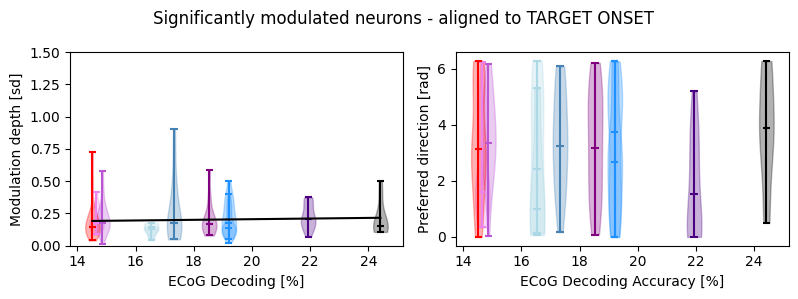

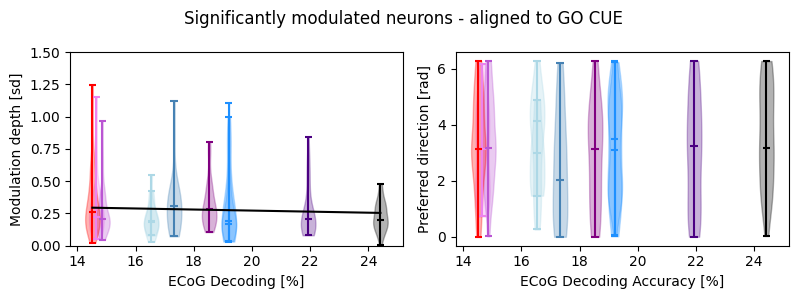

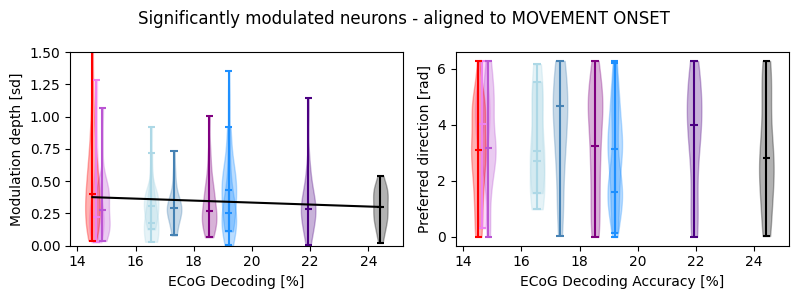

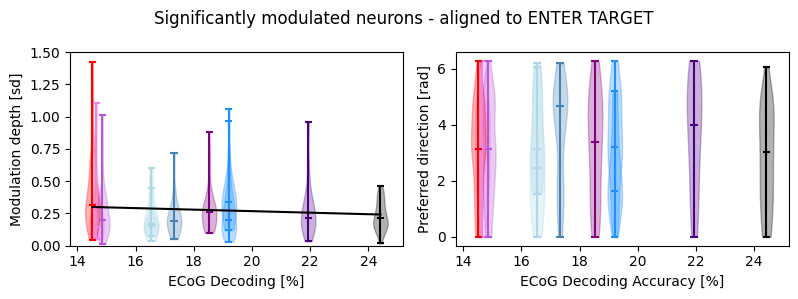

In [19]:
for align_event in align_events:
    fig, ax = plt.subplots(1,2,figsize=(8,3))
    vplts = [ax[0].violinplot(tuning[align_event]['spike_md_sig'][irec], positions=[100*ecog_dec_acc_rec_site[align_event][irec]], showmedians=True, showmeans=False) for irec in range(nrecs)]
    [vplts[irec]['bodies'][0].set_color(day_colors[irec]) for irec in range(nrecs)]
    [vplts[irec]['cbars'].set_colors(day_colors[irec]) for irec in range(nrecs)]
    [vplts[irec]['cmedians'].set_colors(day_colors[irec]) for irec in range(nrecs)]
    [vplts[irec]['cmins'].set_colors(day_colors[irec]) for irec in range(nrecs)]
    [vplts[irec]['cmaxes'].set_colors(day_colors[irec]) for irec in range(nrecs)]
    ax[0].set(xlabel='ECoG Decoding [%]', ylabel='Modulation depth [sd]', ylim=(0,1.5))

    ax[0].plot([100*np.min(ecog_dec_acc_rec_site[align_event]), 100*np.max(ecog_dec_acc_rec_site[align_event])], [(tuning[align_event]['spike_md_reg_fit_sig'].coef_*100*np.min(ecog_dec_acc_rec_site[align_event])+tuning[align_event]['spike_md_reg_fit_sig'].intercept_)[0], (tuning[align_event]['spike_md_reg_fit_sig'].coef_*100*np.max(ecog_dec_acc_rec_site[align_event])+tuning[align_event]['spike_md_reg_fit_sig'].intercept_)[0]], 'k')
    ax[0].annotate(f"Regression p: {np.round(tuning[align_event]['spike_md_pcc_pval_sig'],3)}", (3, 0.5))

    vplts1 = [ax[1].violinplot(tuning[align_event]['spike_pd_sig'][irec], positions=[100*ecog_dec_acc_rec_site[align_event][irec]], showmedians=True, showmeans=False) for irec in range(nrecs)]
    [vplts1[irec]['bodies'][0].set_color(day_colors[irec]) for irec in range(nrecs)]
    [vplts1[irec]['cbars'].set_colors(day_colors[irec]) for irec in range(nrecs)]
    [vplts1[irec]['cmedians'].set_colors(day_colors[irec]) for irec in range(nrecs)]
    [vplts1[irec]['cmins'].set_colors(day_colors[irec]) for irec in range(nrecs)]
    [vplts1[irec]['cmaxes'].set_colors(day_colors[irec]) for irec in range(nrecs)]
    ax[1].set(ylabel='Preferred direction [rad]', xlabel='ECoG Decoding Accuracy [%]')
    fig.suptitle(f"Significantly modulated neurons - aligned to {align_event}")
    fig.tight_layout()
    plt.show()

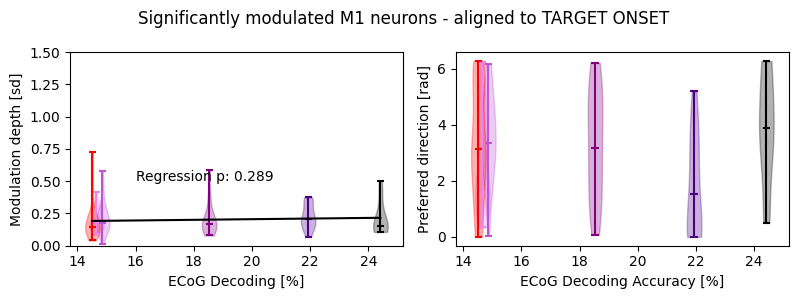

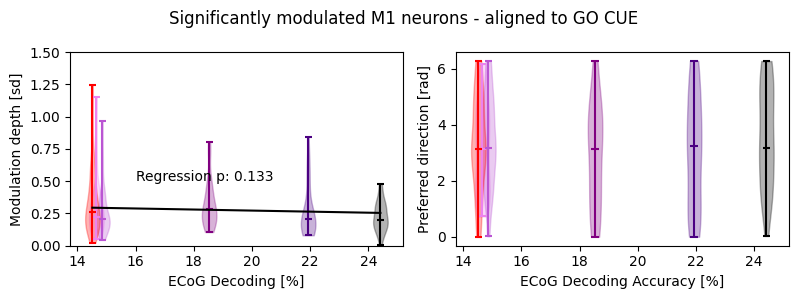

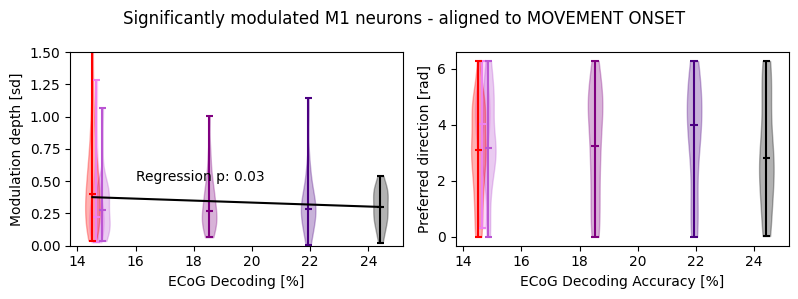

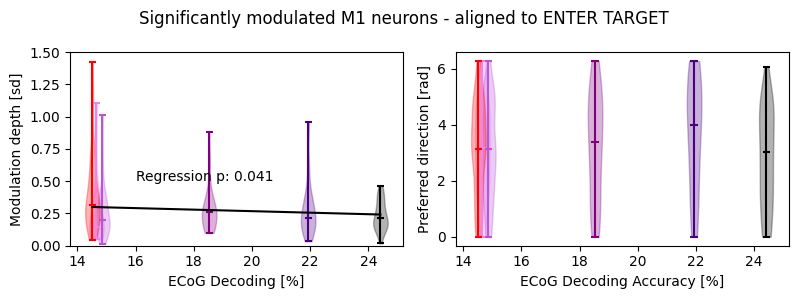

In [20]:
# M1
for align_event in align_events:
    fig, ax = plt.subplots(1,2,figsize=(8,3))
    vplts = [ax[0].violinplot(tuning[align_event]['spike_md_sig'][irec], positions=[100*ecog_dec_acc_rec_site[align_event][irec]], showmedians=True, showmeans=False) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['M1']]
    # [vpltsM1sm[ip]['bodies'][0].set_color(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['M1']))[0][ip]]) for ip in range(len(vpltsM1sm))]
    [vplts[irec]['bodies'][0].set_color(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['M1']))[0][irec]]) for irec in range(len(vplts))]
    [vplts[irec]['cbars'].set_colors(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['M1']))[0][irec]]) for irec in range(len(vplts))]
    [vplts[irec]['cmedians'].set_colors(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['M1']))[0][irec]]) for irec in range(len(vplts))]
    [vplts[irec]['cmins'].set_colors(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['M1']))[0][irec]]) for irec in range(len(vplts))]
    [vplts[irec]['cmaxes'].set_colors(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['M1']))[0][irec]]) for irec in range(len(vplts))]
    ax[0].set(xlabel='ECoG Decoding [%]', ylabel='Modulation depth [sd]', ylim=(0,1.5))

    ax[0].plot([100*np.min(np.array(ecog_dec_acc_rec_site[align_event])[np.where(np.in1d(recording_site,recording_brain_areas['M1']))[0]]), 100*np.max(np.array(ecog_dec_acc_rec_site[align_event])[np.where(np.in1d(recording_site,recording_brain_areas['M1']))[0]])], [(tuning[align_event]['spike_md_reg_fit_sig'].coef_*100*np.min(np.array(ecog_dec_acc_rec_site[align_event])[np.where(np.in1d(recording_site,recording_brain_areas['M1']))[0]])+tuning[align_event]['spike_md_reg_fit_sig'].intercept_)[0], (tuning[align_event]['spike_md_reg_fit_sig'].coef_*100*np.max(np.array(ecog_dec_acc_rec_site[align_event])[np.where(np.in1d(recording_site,recording_brain_areas['M1']))[0]])+tuning[align_event]['spike_md_reg_fit_sig'].intercept_)[0]], 'k')
    ax[0].annotate(f"Regression p: {np.round(tuning[align_event]['spike_md_pcc_pval_M1_sig'],3)}", (16, 0.5))

    vplts1 = [ax[1].violinplot(tuning[align_event]['spike_pd_sig'][irec], positions=[100*ecog_dec_acc_rec_site[align_event][irec]], showmedians=True, showmeans=False) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['M1']]
    [vplts1[irec]['bodies'][0].set_color(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['M1']))[0][irec]]) for irec in range(len(vplts))]
    [vplts1[irec]['cbars'].set_colors(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['M1']))[0][irec]]) for irec in range(len(vplts))]
    [vplts1[irec]['cmedians'].set_colors(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['M1']))[0][irec]]) for irec in range(len(vplts))]
    [vplts1[irec]['cmins'].set_colors(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['M1']))[0][irec]]) for irec in range(len(vplts))]
    [vplts1[irec]['cmaxes'].set_colors(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['M1']))[0][irec]]) for irec in range(len(vplts))]
    ax[1].set(ylabel='Preferred direction [rad]', xlabel='ECoG Decoding Accuracy [%]')
    fig.suptitle(f"Significantly modulated M1 neurons - aligned to {align_event}")
    fig.tight_layout()
    plt.show()

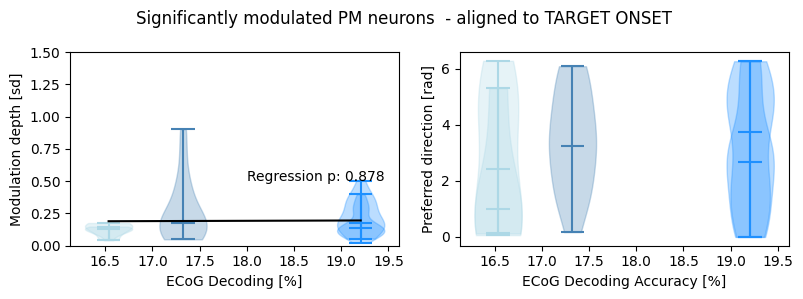

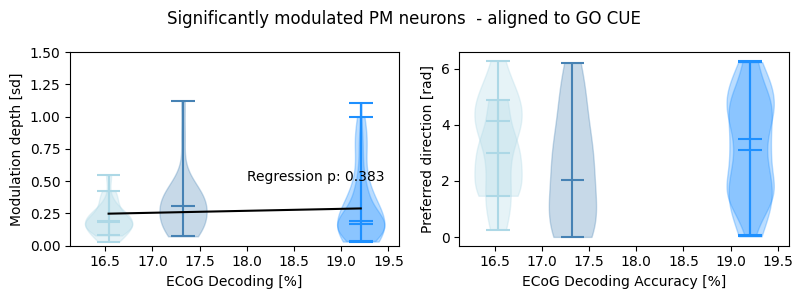

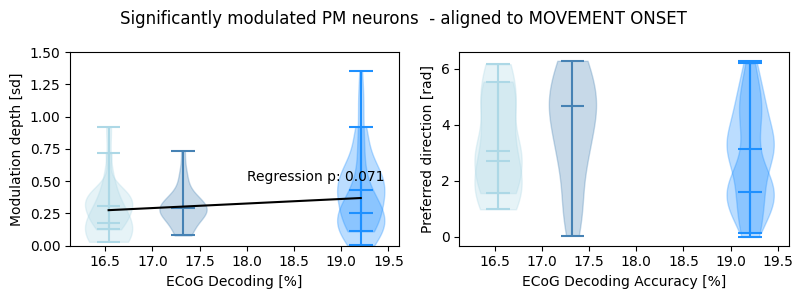

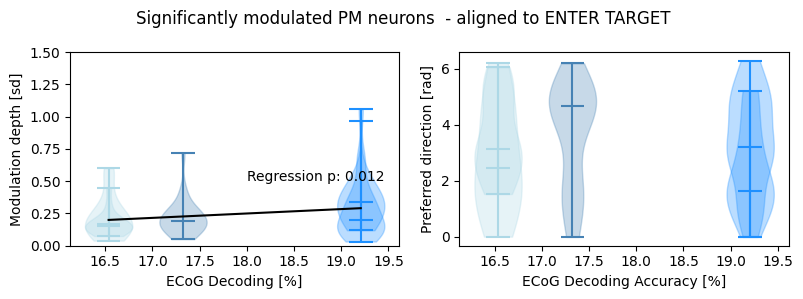

In [21]:
# PM
for align_event in align_events:
    fig, ax = plt.subplots(1,2,figsize=(8,3))
    vplts = [ax[0].violinplot(tuning[align_event]['spike_md_sig'][irec], positions=[100*ecog_dec_acc_rec_site[align_event][irec]], showmedians=True, showmeans=False) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['PM']]
    [vplts[irec]['bodies'][0].set_color(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['PM']))[0][irec]]) for irec in range(len(vplts))]
    [vplts[irec]['cbars'].set_colors(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['PM']))[0][irec]]) for irec in range(len(vplts))]
    [vplts[irec]['cmedians'].set_colors(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['PM']))[0][irec]]) for irec in range(len(vplts))]
    [vplts[irec]['cmins'].set_colors(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['PM']))[0][irec]]) for irec in range(len(vplts))]
    [vplts[irec]['cmaxes'].set_colors(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['PM']))[0][irec]]) for irec in range(len(vplts))]
    ax[0].set(xlabel='ECoG Decoding [%]', ylabel='Modulation depth [sd]',  ylim=(0,1.5))

    ax[0].plot([100*np.min(np.array(ecog_dec_acc_rec_site[align_event])[np.where(np.in1d(recording_site,recording_brain_areas['PM']))[0]]), 100*np.max(np.array(ecog_dec_acc_rec_site[align_event])[np.where(np.in1d(recording_site,recording_brain_areas['PM']))[0]])], [(tuning[align_event]['spike_md_reg_fit_PM_sig'].coef_*100*np.min(np.array(ecog_dec_acc_rec_site[align_event])[np.where(np.in1d(recording_site,recording_brain_areas['PM']))[0]])+tuning[align_event]['spike_md_reg_fit_PM_sig'].intercept_)[0], (tuning[align_event]['spike_md_reg_fit_PM_sig'].coef_*100*np.max(np.array(ecog_dec_acc_rec_site[align_event])[np.where(np.in1d(recording_site,recording_brain_areas['PM']))[0]])+tuning[align_event]['spike_md_reg_fit_PM_sig'].intercept_)[0]], 'k')
    ax[0].annotate(f"Regression p: {np.round(tuning[align_event]['spike_md_pcc_pval_PM_sig'],3)}", (18, 0.5))

    vplts1 = [ax[1].violinplot(tuning[align_event]['spike_pd_sig'][irec], positions=[100*ecog_dec_acc_rec_site[align_event][irec]], showmedians=True, showmeans=False) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['PM']]
    [vplts1[irec]['bodies'][0].set_color(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['PM']))[0][irec]]) for irec in range(len(vplts))]
    [vplts1[irec]['cbars'].set_colors(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['PM']))[0][irec]]) for irec in range(len(vplts))]
    [vplts1[irec]['cmedians'].set_colors(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['PM']))[0][irec]]) for irec in range(len(vplts))]
    [vplts1[irec]['cmins'].set_colors(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['PM']))[0][irec]]) for irec in range(len(vplts))]
    [vplts1[irec]['cmaxes'].set_colors(day_colors[np.where(np.in1d(recording_site,recording_brain_areas['PM']))[0][irec]]) for irec in range(len(vplts))]
    ax[1].set(ylabel='Preferred direction [rad]', xlabel='ECoG Decoding Accuracy [%]')
    fig.suptitle(f"Significantly modulated PM neurons  - aligned to {align_event}")
    fig.tight_layout()
    plt.show()

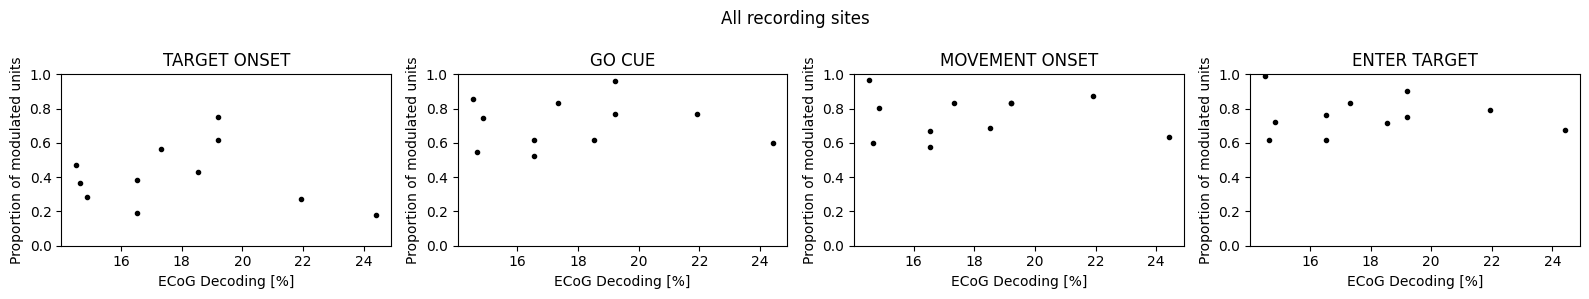

In [23]:
# Plot proportion of significantly modulated units at each recording site
fig, ax = plt.subplots(1,len(align_events),figsize=(len(align_events)*4,3))
for iae, align_event in enumerate(align_events):
    [ax[iae].plot([100*ecog_dec_acc_rec_site[align_event][irec]], len(tuning[align_event]['spike_md_sig'][irec])/len(tuning[align_event]['spike_md'][irec]),'k.') for irec in range(nrecs)]
    ax[iae].set(xlabel='ECoG Decoding [%]', ylabel='Proportion of modulated units', ylim=(0, 1), title=align_event)
plt.suptitle('All recording sites')
fig.tight_layout()
plt.show()

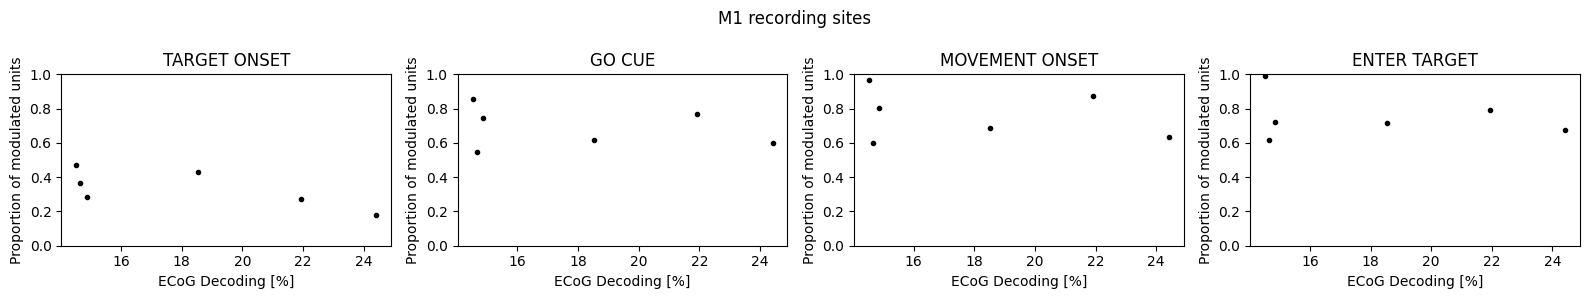

In [25]:
# Plot proportion of significantly modulated units at each recording site
fig, ax = plt.subplots(1,len(align_events),figsize=(len(align_events)*4,3))
for iae, align_event in enumerate(align_events):
    [ax[iae].plot([100*ecog_dec_acc_rec_site[align_event][irec]], len(tuning[align_event]['spike_md_sig'][irec])/len(tuning[align_event]['spike_md'][irec]),'k.') for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['M1']]
    ax[iae].set(xlabel='ECoG Decoding [%]', ylabel='Proportion of modulated units', ylim=(0, 1), title=align_event)
plt.suptitle('M1 recording sites')
fig.tight_layout()
plt.show()

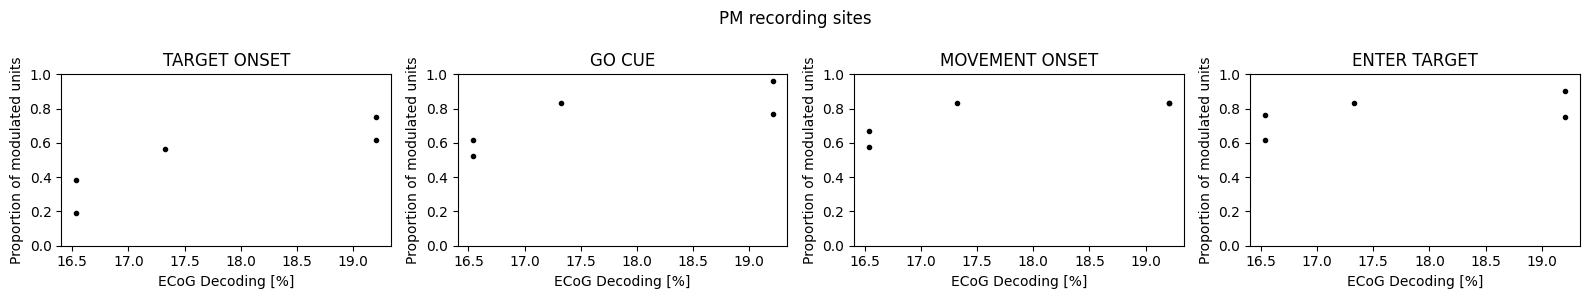

In [26]:
# Plot proportion of significantly modulated units at each recording site
fig, ax = plt.subplots(1,len(align_events),figsize=(len(align_events)*4,3))
for iae, align_event in enumerate(align_events):
    [ax[iae].plot([100*ecog_dec_acc_rec_site[align_event][irec]], len(tuning[align_event]['spike_md_sig'][irec])/len(tuning[align_event]['spike_md'][irec]),'k.') for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['PM']]
    ax[iae].set(xlabel='ECoG Decoding [%]', ylabel='Proportion of modulated units', ylim=(0, 1), title=align_event)
plt.suptitle('PM recording sites')
fig.tight_layout()
plt.show()

## Trial adding

In [ ]:
# for align_event in align_events:
#     fig, ax = plt.subplots(1,len(tuning_tradd[align_event]['spike_md']),figsize=(len(tuning_tradd[align_event]['spike_md'])*4,3))
#     for itradd in range(len(tuning_tradd[align_event]['spike_md'])):
        
#         vplts = [ax[itradd].violinplot(tuning_tradd[align_event]['spike_md'][itradd][irec], positions=[100*ecog_dec_acc['beignet']['NPinsert72_interp'][recording_site[irec]]], showmedians=True, showmeans=False) for irec in range(nrecs)]
#         # for iday in parts['bodies']:
#         [vplts[irec]['bodies'][0].set_color(day_colors[irec]) for irec in range(nrecs)]
#         [vplts[irec]['cbars'].set_colors(day_colors[irec]) for irec in range(nrecs)]
#         [vplts[irec]['cmedians'].set_colors(day_colors[irec]) for irec in range(nrecs)]
#         [vplts[irec]['cmins'].set_colors(day_colors[irec]) for irec in range(nrecs)]
#         [vplts[irec]['cmaxes'].set_colors(day_colors[irec]) for irec in range(nrecs)]
#         ax[itradd].set(xlabel="ECoG Decoding Accuracy", ylabel="Zscored MD", title=f"{(itradd+1)*ntrial_bin_size} trials")
        
#     plt.suptitle(align_event)
#     fig.tight_layout()
#     plt.show()

### All recording sites

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(12,3))
[ax[iae].plot(np.arange(1,ntrial_adding_bins+1)*ntrial_bin_size, tuning_tradd[align_event]['spike_md_pcc_pval']) for iae, align_event in enumerate(align_events)]
[ax[iae].set(xlabel = 'Trials Used', ylabel='Slope p-value', title=f"{align_event}") for iae, align_event in enumerate(align_events)]
[ax[iae].plot([0, ntrial_adding_bins*ntrial_bin_size], [0.05, 0.05], 'r--') for iae, align_event in enumerate(align_events)]
for iax, align_event in enumerate(align_events):
    slopes = [tuning_tradd[align_event]['spike_md_reg_fit'][itradd].coef_ for itradd in range(ntrial_adding_bins)]
    twinax = ax[iax].twinx()
    twinax.plot(np.arange(1,ntrial_adding_bins+1)*ntrial_bin_size, np.squeeze(np.array(slopes)), 'k')
    twinax.set(ylabel='Slope')
plt.suptitle('All units')
fig.tight_layout()
plt.show()

### Split by brain area

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(12,3))
[ax[iae].plot(np.arange(1,ntrial_adding_bins+1)*ntrial_bin_size, tuning_tradd[align_event]['spike_md_pcc_pval_M1']) for iae, align_event in enumerate(align_events)]
[ax[iae].set(xlabel = 'Trials Used', ylabel='Slope p-value', title=f"{align_event}") for iae, align_event in enumerate(align_events)]
[ax[iae].plot([0, ntrial_adding_bins*ntrial_bin_size], [0.05, 0.05], 'r--') for iae, align_event in enumerate(align_events)]
for iax, align_event in enumerate(align_events):
    slopes = [tuning_tradd[align_event]['spike_md_reg_fit_M1'][itradd].coef_ for itradd in range(ntrial_adding_bins)]
    twinax = ax[iax].twinx()
    twinax.plot(np.arange(1,ntrial_adding_bins+1)*ntrial_bin_size, np.squeeze(np.array(slopes)), 'k')
    twinax.set(ylabel='Slope (black)')
plt.suptitle('All units - M1')
fig.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(12,3))
[ax[iae].plot(np.arange(1,ntrial_adding_bins+1)*ntrial_bin_size, tuning_tradd[align_event]['spike_md_pcc_pval_PM']) for iae, align_event in enumerate(align_events)]
[ax[iae].set(xlabel = 'Trials Used', ylabel='Slope p-value (blue)', title=f"{align_event}") for iae, align_event in enumerate(align_events)]
[ax[iae].plot([0, ntrial_adding_bins*ntrial_bin_size], [0.05, 0.05], 'r--') for iae, align_event in enumerate(align_events)]
for iax, align_event in enumerate(align_events):
    slopes = [tuning_tradd[align_event]['spike_md_reg_fit_PM'][itradd].coef_ for itradd in range(ntrial_adding_bins)]
    twinax = ax[iax].twinx()
    twinax.plot(np.arange(1,ntrial_adding_bins+1)*ntrial_bin_size, np.squeeze(np.array(slopes)), 'k')
    twinax.set(ylabel='Slope')
plt.suptitle('All units - PM')
fig.tight_layout()
plt.show()

### Significantly modulated units

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(12,3))
[ax[iae].plot(np.arange(1,ntrial_adding_bins+1)*ntrial_bin_size, tuning_tradd[align_event]['spike_md_pcc_pval_sig']) for iae, align_event in enumerate(align_events)]
[ax[iae].set(xlabel = 'Trials Used', ylabel='Slope p-value', title=f"{align_event}") for iae, align_event in enumerate(align_events)]
[ax[iae].plot([0, ntrial_adding_bins*ntrial_bin_size], [0.05, 0.05], 'r--') for iae, align_event in enumerate(align_events)]
for iax, align_event in enumerate(align_events):
    slopes = [tuning_tradd[align_event]['spike_md_reg_fit_sig'][itradd].coef_ for itradd in range(ntrial_adding_bins)]
    twinax = ax[iax].twinx()
    twinax.plot(np.arange(1,ntrial_adding_bins+1)*ntrial_bin_size, np.squeeze(np.array(slopes)), 'k')
    twinax.set(ylabel='Slope')
plt.suptitle('Significantly modulated units')
fig.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(12,3))
[ax[iae].plot(np.arange(1,ntrial_adding_bins+1)*ntrial_bin_size, tuning_tradd[align_event]['spike_md_pcc_pval_M1_sig']) for iae, align_event in enumerate(align_events)]
[ax[iae].set(xlabel = 'Trials Used', ylabel='Slope p-value', title=f"{align_event}") for iae, align_event in enumerate(align_events)]
[ax[iae].plot([0, ntrial_adding_bins*ntrial_bin_size], [0.05, 0.05], 'r--') for iae, align_event in enumerate(align_events)]
for iax, align_event in enumerate(align_events):
    slopes = [tuning_tradd[align_event]['spike_md_reg_fit_M1_sig'][itradd].coef_ for itradd in range(ntrial_adding_bins)]
    twinax = ax[iax].twinx()
    twinax.plot(np.arange(1,ntrial_adding_bins+1)*ntrial_bin_size, np.squeeze(np.array(slopes)), 'k')
    twinax.set(ylabel='Slope (black)')
plt.suptitle('Significantly modulated units - M1')
fig.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(12,3))
[ax[iae].plot(np.arange(1,ntrial_adding_bins+1)*ntrial_bin_size, tuning_tradd[align_event]['spike_md_pcc_pval_PM_sig']) for iae, align_event in enumerate(align_events)]
[ax[iae].set(xlabel = 'Trials Used', ylabel='Slope p-value (blue)', title=f"{align_event}") for iae, align_event in enumerate(align_events)]
[ax[iae].plot([0, ntrial_adding_bins*ntrial_bin_size], [0.05, 0.05], 'r--') for iae, align_event in enumerate(align_events)]
for iax, align_event in enumerate(align_events):
    slopes = [tuning_tradd[align_event]['spike_md_reg_fit_PM_sig'][itradd].coef_ for itradd in range(ntrial_adding_bins)]
    twinax = ax[iax].twinx()
    twinax.plot(np.arange(1,ntrial_adding_bins+1)*ntrial_bin_size, np.squeeze(np.array(slopes)), 'k')
    twinax.set(ylabel='Slope')
plt.suptitle('Significantly modulated units - PM')
fig.tight_layout()
plt.show()

## Early - late comparison

KeyError: 'early_spike_md'

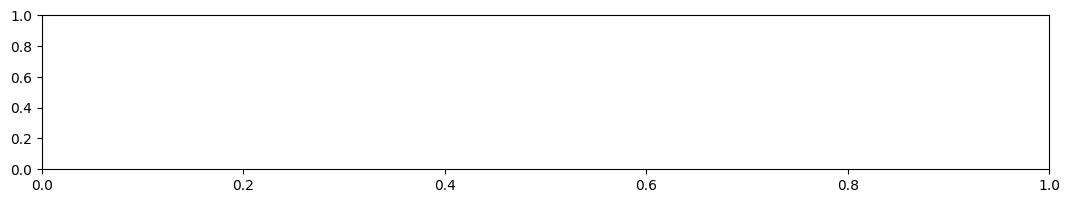

In [27]:
# for align_event in align_events:
for irec in range(nrecs):
    fig, ax = plt.subplots(1,1,figsize=(13,2))
    delta_md = tuning[align_events[-1]]['early_spike_md'][irec][stable_unit_idx[irec]] - tuning[align_events[-1]]['late_spike_md'][irec][stable_unit_idx[irec]]
    delta_pd = np.abs(tuning[align_events[-1]]['early_spike_pd'][irec][stable_unit_idx[irec]] - tuning[align_events[-1]]['late_spike_pd'][irec][stable_unit_idx[irec]])
    ax.plot(delta_pd[np.argsort(delta_pd)], color=day_colors[irec])
    ax.plot([0,len(delta_pd)], [np.deg2rad(45), np.deg2rad(45)], color='darkgreen')
    ax.plot([0,len(delta_pd)], [2*np.pi-np.deg2rad(45), 2*np.pi-np.deg2rad(45)], color='darkgreen')
    ax02 = ax.twinx()
    ax02.plot(delta_md[np.argsort(delta_pd)], '--', color=day_colors[irec])
    ax.set_xticks(np.arange(len(delta_pd)), stable_unit_labels[irec][np.argsort(delta_pd)], rotation=90)
    ax.set(xlabel='Unit number', ylabel='dPD', ylim=(-.5, 2*np.pi))
    ax02.set(ylabel='dMD')
    plt.suptitle(f"Tuning changes between early and late trials ({ntr_early_late} trials each). Aligned to {align_events[-1]}")
    fig.tight_layout()
    # ax[1].set_xticks(np.arange(len(stable_unit_idx[irec])), stable_unit_idx[irec], rotation=90)

### Consistent PD neuron tuning

KeyError: 'cons_spike_md'

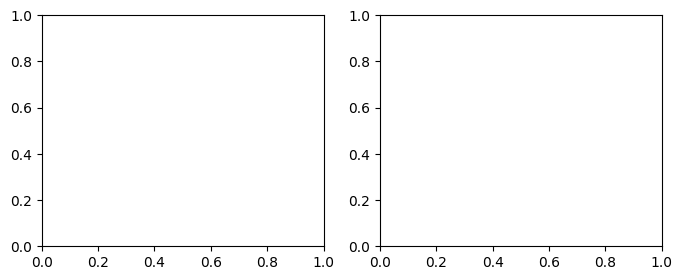

In [28]:
for align_event in align_events:
    fig, ax = plt.subplots(1,2,figsize=(8,3))
    vplts = [ax[0].violinplot(tuning[align_event]['cons_spike_md'][irec], positions=[100*ecog_dec_acc_rec_site[align_event][irec]], showmedians=True, showmeans=False) for irec in range(nrecs)]
    [vplts[irec]['bodies'][0].set_color(day_colors[irec]) for irec in range(nrecs)]
    [vplts[irec]['cbars'].set_colors(day_colors[irec]) for irec in range(nrecs)]
    [vplts[irec]['cmedians'].set_colors(day_colors[irec]) for irec in range(nrecs)]
    [vplts[irec]['cmins'].set_colors(day_colors[irec]) for irec in range(nrecs)]
    [vplts[irec]['cmaxes'].set_colors(day_colors[irec]) for irec in range(nrecs)]
    ax[0].set(xlabel='ECoG Decoding [%]', ylabel='Modulation depth [sd]', ylim=(0,1.5), title=align_event)

    # ax[0].plot([100*np.min(ecog_dec_acc_rec_site[align_event]), 100*np.max(ecog_dec_acc_rec_site[align_event])], [(tuning[align_event]['spike_md_reg_fit'].coef_*100*np.min(ecog_dec_acc_rec_site[align_event])+tuning[align_event]['spike_md_reg_fit'].intercept_)[0], (tuning[align_event]['spike_md_reg_fit'].coef_*100*np.max(ecog_dec_acc_rec_site[align_event])+tuning[align_event]['spike_md_reg_fit'].intercept_)[0]], 'k')
    # ax[0].annotate(f"Regression p: {np.round(tuning[align_event]['spike_md_pcc_pval'],3)}", (16, 0.5))

    vplts1 = [ax[1].violinplot(tuning[align_event]['cons_spike_pd'][irec], positions=[100*ecog_dec_acc_rec_site[align_event][irec]], showmedians=True, showmeans=False) for irec in range(nrecs)]
    [vplts1[irec]['bodies'][0].set_color(day_colors[irec]) for irec in range(nrecs)]
    [vplts1[irec]['cbars'].set_colors(day_colors[irec]) for irec in range(nrecs)]
    [vplts1[irec]['cmedians'].set_colors(day_colors[irec]) for irec in range(nrecs)]
    [vplts1[irec]['cmins'].set_colors(day_colors[irec]) for irec in range(nrecs)]
    [vplts1[irec]['cmaxes'].set_colors(day_colors[irec]) for irec in range(nrecs)]
    ax[1].set(ylabel='Preferred direction [rad]', xlabel='ECoG Decoding Accuracy [%]', title=align_event)
    fig.suptitle(f"Consistent neurons - aligned to {align_event}")
    fig.tight_layout()
    plt.show()

## Timing

In [ ]:
fig, ax = plt.subplots(1,nrecs, figsize=(nrecs*2, 3))
[ax[irec].hist(tuning['timing']['delta_Mon-Ton'][irec]) for irec in range(nrecs)]
[ax[irec].set( xlabel='T_on - Mov_on MD', ylabel='Unit count', xlim=(-.5,1.5), ylim=(0,32)) for irec in range(nrecs)]
[ax[irec].set_title(str(np.round(ecog_dec_acc_rec_site[align_event][irec],3)), color=day_colors[irec]) for irec in range(nrecs)]
fig.tight_layout()
plt.show()

## Depth

In [ ]:
# Plot tuning as a function of depth for all units
for align_event in align_events:
    fig, ax = plt.subplots(1,nrecs,figsize=(nrecs*2,4.5))
    [ax[irec].plot(tuning[align_event]['spike_md'][irec], np.array(neuron_pos[irec]), '.', color=day_colors[irec]) for irec in range(nrecs)]
    [ax[irec].set(title=str(np.round(ecog_dec_acc_rec_site[align_event][irec],3)), xlabel='MD', ylabel='Depth', xlim=(0,1.5), ylim=(0,4000)) for irec in range(nrecs)]
    [ax[irec].invert_yaxis() for irec in range(nrecs)]
    plt.suptitle(align_event)
    fig.tight_layout()
    plt.show()

In [ ]:
# Plot tuning as a function of depth for all units
for align_event in align_events:    
    fig, ax = plt.subplots(1,nrecs,figsize=(nrecs*2,4.5))
    for irec in range(nrecs):
        unit_idx_plot = np.where(tuning[align_event]['spike_md'][irec])[0]
        for unit_idx in unit_idx_plot:
            xoffset = tuning[align_event]['spike_md'][irec][unit_idx]
            yoffset = neuron_pos[irec][unit_idx]
            norm_wf =  150*qc_results['mean_wfs'][irec][unit_idx,:]/np.max(np.abs(qc_results['mean_wfs'][irec][unit_idx,:]))
            ax[irec].plot(xoffset+np.arange(-nwf_pts/2, nwf_pts/2)/180, yoffset+norm_wf)
            
        ax[irec].set(xlabel='MD', ylabel='Depth', xlim=(0,1.5), ylim=(0,4000), alpha=0.7)
        ax[irec].set_title(str(np.round(ecog_dec_acc_rec_site[align_event][irec],3)), color=day_colors[irec])
        ax[irec].invert_yaxis()
    
    plt.suptitle(f"{align_event}")
    fig.tight_layout()
    plt.show()

In [ ]:
# Plot tuning as a function of depth for all units
for align_event in align_events:
    fig, ax = plt.subplots(1,nrecs,figsize=(nrecs*2,4.5))
    [ax[irec].plot(tuning[align_event]['spike_md_sig'][irec], np.array(neuron_pos[irec])[tuning[align_event]['spike_md_sig_idx'][irec]], '.', color=day_colors[irec]) for irec in range(nrecs)]
    [ax[irec].set(title=str(np.round(ecog_dec_acc_rec_site[align_event][irec],3)), xlabel='MD', ylabel='Depth', xlim=(0,1.75), ylim=(0,4000)) for irec in range(nrecs)]
    [ax[irec].invert_yaxis() for irec in range(nrecs)]
    plt.suptitle(f"{align_event} - Significantly modulated units")
    fig.tight_layout()
    plt.show()

In [ ]:
# Plot tuning as a function of depth for all units
for align_event in align_events:    
    fig, ax = plt.subplots(1,nrecs,figsize=(nrecs*2,4.5))
    for irec in range(nrecs):
        unit_idx_plot = np.where(tuning[align_event]['spike_md_sig_idx'][irec])[0]
        for unit_idx in unit_idx_plot:
            xoffset = tuning[align_event]['spike_md'][irec][unit_idx]
            yoffset = neuron_pos[irec][unit_idx]
            norm_wf =  150*qc_results['mean_wfs'][irec][unit_idx,:]/np.max(np.abs(qc_results['mean_wfs'][irec][unit_idx,:]))
            ax[irec].plot(xoffset+np.arange(-nwf_pts/2, nwf_pts/2)/180, yoffset+norm_wf)
            
        ax[irec].set(xlabel='MD', ylabel='Depth', xlim=(0,1.75), ylim=(0,4000), alpha=0.7)
        ax[irec].set_title(str(np.round(ecog_dec_acc_rec_site[align_event][irec],3)), color=day_colors[irec])
        ax[irec].invert_yaxis()
    
    plt.suptitle(f"{align_event} - Significantly modulated units")
    fig.tight_layout()
    plt.show()